In [1]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

import matplotlib.pyplot as plt


import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import scipy.io as sio

from tqdm import trange, tqdm

# Import the single DOF finite difference model
from mlp_singledof_gru import MLP, MLPProjectionFilter, CustomGRULayer, GRU_Hidden_State


/home/alinjar/simple_training_warm_start


In [2]:
class TrajDataset(Dataset):
	"""Expert Trajectory Dataset."""
	def __init__(self, inp):
		
		# input
		self.inp = inp

	
	def __len__(self):
		return len(self.inp)    
			
	def __getitem__(self, idx):

		# Input
  
		inp = self.inp[idx]
		
				 
		return torch.tensor(inp).float()

In [3]:
def sample_uniform_trajectories(key, v_max, num_batch, nvar):
    rng = np.random.default_rng(seed=key)
    xi_samples = rng.uniform(
        low=-v_max,
        high=v_max,
        size=(num_batch, nvar)
    )
    return xi_samples, rng

In [4]:
#Parameters for MLP model

num_batch = 1000
num_dof=1
num_steps=50
timestep=0.05
v_max=1.0
a_max=2.0
j_max=5.0
p_max=180.0*np.pi/180.0 
theta_init=0.0
maxiter_projection = 20
nvar_single = num_steps
nvar = num_dof * nvar_single

In [5]:
#calculating number of constraints
num_acc = num_steps - 1
num_jerk = num_acc - 1
num_pos = num_steps
num_vel_constraints = 2 * num_steps * num_dof
num_acc_constraints = 2 * num_acc * num_dof
num_jerk_constraints = 2 * num_jerk * num_dof
num_pos_constraints = 2 * num_pos * num_dof
num_total_constraints = (num_vel_constraints + num_acc_constraints + 
                            num_jerk_constraints + num_pos_constraints)

##Maximum Iterations
maxiter_projection = 20

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

xi_samples, rng = sample_uniform_trajectories(42, v_max, num_batch, nvar)
xi_val, rng = sample_uniform_trajectories(0, v_max, num_batch, nvar)

inp = xi_samples
inp_val = xi_val

inp_mean, inp_std = inp.mean(), inp.std()

print("inp", inp.shape)

Using cuda device
inp (1000, 50)


In [7]:
# Using PyTorch Dataloader
train_dataset = TrajDataset(inp)
val_dataset = TrajDataset(inp_val)

train_loader = DataLoader(train_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)


In [8]:

#GRU handling

gru_input_size = 3*num_total_constraints+3*nvar
# print(gru_input_size)
gru_hidden_size = 512
# gru_output_size = (2*nvar)**2+2*nvar
gru_output_size = num_total_constraints+nvar
# gru_context_size = mlp_planner_inp_dim

gru_context = CustomGRULayer(gru_input_size, gru_hidden_size, gru_output_size)


input_hidden_state_init = np.shape(inp)[1]
mid_hidden_state_init = 512
out_hidden_state_init = gru_hidden_size

gru_init  =  GRU_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)

##


In [9]:

enc_inp_dim = np.shape(inp)[1] 
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 2*nvar + num_total_constraints #( xi_samples- 0:nvar, lamda_smples- nvar:2*nvar)

mlp =  MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)

In [10]:


model = MLPProjectionFilter(mlp=mlp,gru_context=gru_context, gru_init = gru_init, num_batch = num_batch,num_dof=num_dof,num_steps=num_steps,
							timestep=timestep,v_max=v_max,a_max=a_max,j_max=j_max,p_max=p_max, 
							theta_init=theta_init, maxiter_projection=maxiter_projection).to(device)

print(type(model))                            

<class 'mlp_singledof_gru.MLPProjectionFilter'>


In [11]:
#Training

epochs = 500
#step, beta = 0, 1.0 # 3.5
optimizer = optim.AdamW(model.parameters(), lr = 1e-5, weight_decay=6e-5)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1)
losses = []
last_loss = torch.inf
avg_train_loss, avg_primal_loss, avg_fixed_point_loss, avg_projection_loss = [], [], [], []
avg_val_loss = []
for epoch in range(epochs):
    
    # Train Loop
    losses_train, primal_losses, fixed_point_losses, projection_losses = [], [], [], []
    
    for (inp) in tqdm(train_loader):
        
        # Input and Output 
        inp = inp.to(device)
        

        xi_projected, accumulated_res_fixed_point, accumulated_res_primal, accumulated_res_primal_temp, accumulated_res_fixed_point_temp = model(inp)
        primal_loss, fixed_point_loss, projection_loss, loss = model.mlp_loss(accumulated_res_primal, accumulated_res_fixed_point, inp, xi_projected)

        
        optimizer.zero_grad() #clears the gradients of the model parameters
        loss.backward() #computes the gradients of the model parameters
        
        
        # #Gradient Norm check
        # total_norm = 0.0
        # for p in model.parameters():
        #     if p.grad is not None:
        #         param_norm = p.grad.data.norm(2)  # L2 norm
        #         total_norm += param_norm.item() ** 2

        # total_norm = total_norm ** 0.5
        # print(f"Gradient L2 norm: {total_norm:.4f}")
        
        ##Gradient Norm clipping
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


        optimizer.step() #updates the model parameters (e.g. weights and biases)
        
        losses_train.append(loss.detach().cpu().numpy()) 
        primal_losses.append(primal_loss.detach().cpu().numpy())
        fixed_point_losses.append(fixed_point_loss.detach().cpu().numpy())
        projection_losses.append(projection_loss.detach().cpu().numpy())
        
    if epoch % 2 == 0:
        
        # Validation 
        model.eval()
        val_losses = []

        with torch.no_grad():
            for (inp_val) in tqdm(val_loader):
                inp_val = inp_val.to(device)

                xi_projected, accumulated_res_fixed_point, accumulated_res_primal, \
                accumulated_res_primal_temp, accumulated_res_fixed_point_temp = model(inp_val)

                _, _, _, val_loss = model.mlp_loss(
                    accumulated_res_primal, accumulated_res_fixed_point, inp_val, xi_projected
                )

                val_losses.append(val_loss.detach().cpu().numpy())

                #print(f"Validation Loss: {np.average(val_losses):.4f}")
            

    
    os.makedirs("./training_weights", exist_ok=True)
    #if mean_val_loss <= last_loss:
    if loss <= last_loss:
            torch.save(model.state_dict(), f"./training_weights/mlp_learned_single_dof_gru.pth")
            last_loss = loss

    avg_train_loss.append(np.average(losses_train)), avg_primal_loss.append(np.average(primal_losses)), \
    avg_projection_loss.append(np.average(projection_losses)), avg_fixed_point_loss.append(np.average(fixed_point_losses))
    avg_val_loss.append(np.average(val_losses))

100%|██████████| 1/1 [00:00<00:00, 32.00it/s]


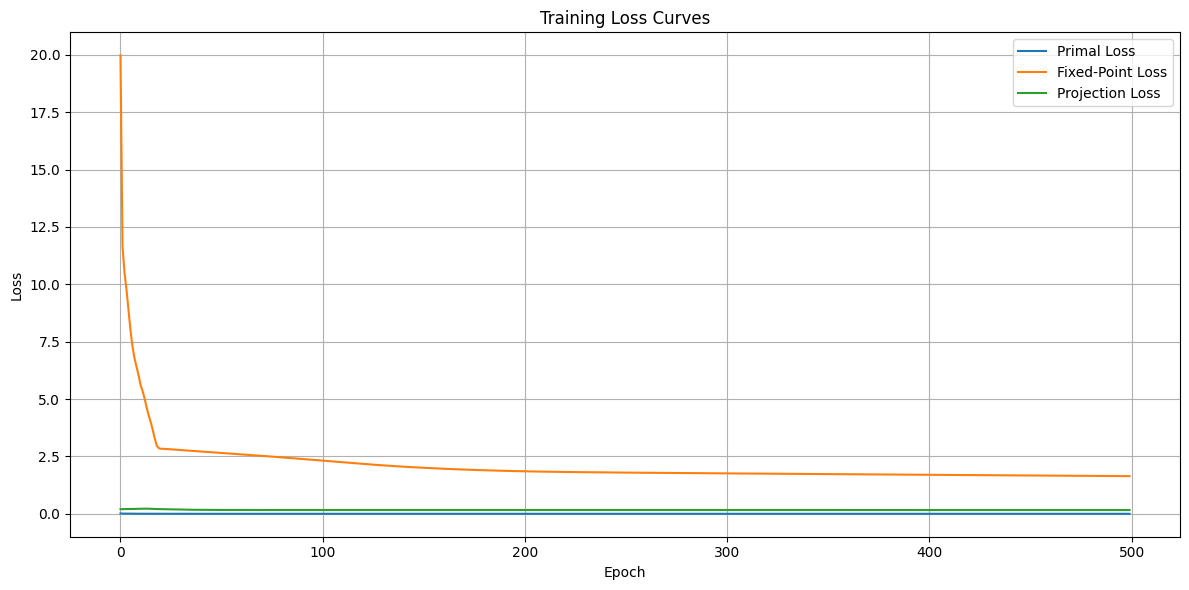

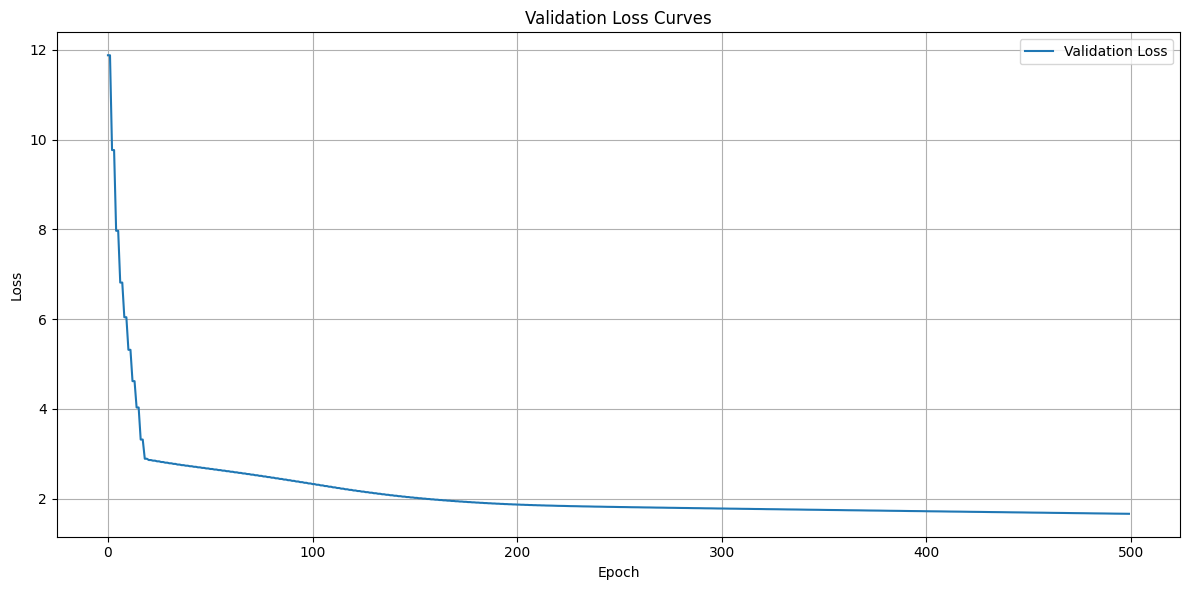

In [12]:
# Plot training losses

plt.figure(figsize=(12, 6))

#plt.plot(avg_train_loss, label='Total Loss')
plt.plot(avg_primal_loss, label='Primal Loss')
plt.plot(avg_fixed_point_loss, label='Fixed-Point Loss')
plt.plot(avg_projection_loss, label='Projection Loss')


plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot validation losses
plt.figure(figsize=(12, 6))
plt.plot(avg_val_loss, label='Validation Loss')

plt.title('Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
avg_train_loss = np.asarray(avg_train_loss)
avg_val_loss = np.asarray(avg_val_loss)
print("Training_loss_end", avg_train_loss[-1])
print("Validation_loss_end", avg_val_loss[-1])

Training_loss_end 1.6573735
Validation_loss_end 1.6610111
